# Introduction

Currently, one of the most common (and accurate) methods for conducting a Blood
Smear is manually. The goal of this project is to develop a neural network that can classify WBCs from images as part of an eventual effort to automate the procedure without a significant loss in accuracy. By automating this process, we can not only speed it up, but we also reduce the amount of human labor required to conduct a test, thus lowering the overall cost.

The dataset for this project is a collection of ~12,500 images that are 240 x 320. The images contain several RBCs and a single, highlighted WBC. Each WBC falls into one of four categories: Eosinophil, Lymphocyte, Monocyte, or Neutrophil. The dataset can be found on Kaggle [here](https://www.kaggle.com/paultimothymooney/blood-cells). Through accurate classification, accurate proportions of each WBC type could be calculated and checked for normalcy. Additionally, cell images could be further inspected for abnormalities.

# Module Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline



import warnings  
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Data Exploration

Let's begin by taking a look at an example of each of the four types of WBC we'll be attempting to classify.

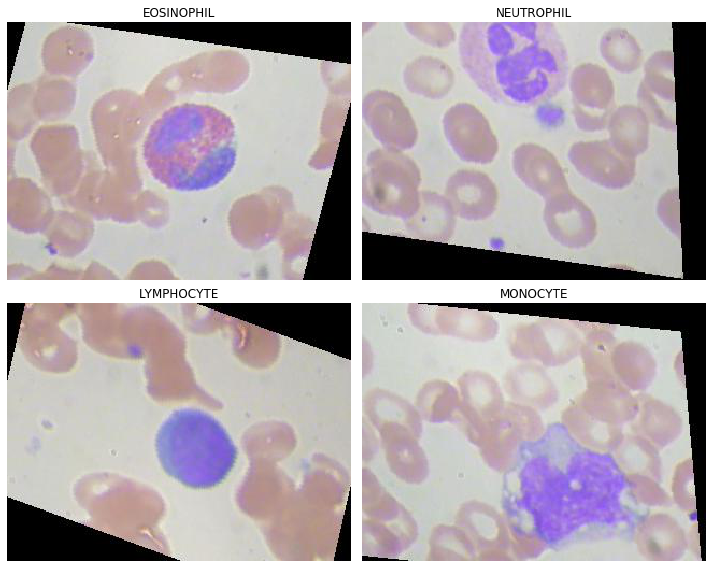

In [2]:
wbc_types = ['EOSINOPHIL', 'NEUTROPHIL', 'LYMPHOCYTE', 'MONOCYTE']
wbc_df = pd.DataFrame(columns=['file_name', 'type'])

plt.figure(figsize=(10,8))

for i, wbc_type in enumerate(wbc_types):
    path = 'dataset2-master/images/TRAIN/' + wbc_type + '/'
    files = os.listdir(path)
    
    df = pd.DataFrame(columns=['file_name', 'type'])
    df['file_name'] = files
    df.fillna(value=wbc_type, inplace=True)
    wbc_df = wbc_df.append(df)
    
    image = load_img(path + files[0])
    plt.subplot(2,2,i+1)
    plt.title(wbc_type)
    plt.axis('off')
    plt.imshow(image)
    
plt.tight_layout()
plt.show()

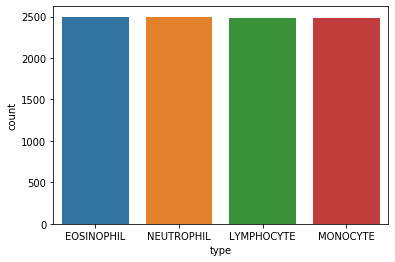

In [3]:
sns.countplot(x='type', data=wbc_df)
plt.show()

The images show that each of the four cell types are quite easily visually differentiable. Additionally, we can see from the countplot that our training data is very well balanced with ~2,500 images of each WBC cell type.

# Model Construction

Since the input to be classified are image files, we will be using a Convolutional Neural Network for these purposes. 

In [10]:
# model accuracy reached 0.3155 after 1.5 hours and 30 epochs
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(60,80,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Dense(4))
model.add(Activation('softmax'))

optimizer = tf.keras.optimizers.Adadelta()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [11]:
batch_size = 128

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolders of 'dataset2-master/images/TRAIN', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'dataset2-master/images/TRAIN',  # this is the target directory
        target_size=(60, 80),  # all images will be resized to 60x80
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'dataset2-master/images/TEST',
        target_size=(60, 80),
        batch_size=batch_size,
        class_mode='categorical')

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [12]:
model.fit_generator(
        train_generator,
        steps_per_epoch=9957 // 32,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=2487 // 32)
model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/30
311/311 [==============================] - 181s 583ms/step - loss: 1.3865 - acc: 0.2525 - val_loss: 1.3871 - val_acc: 0.2373
Epoch 2/30
311/311 [==============================] - 176s 565ms/step - loss: 1.3859 - acc: 0.2545 - val_loss: 1.3869 - val_acc: 0.2448
Epoch 3/30
311/311 [==============================] - 177s 568ms/step - loss: 1.3857 - acc: 0.2587 - val_loss: 1.3866 - val_acc: 0.2403
Epoch 4/30
311/311 [==============================] - 177s 570ms/step - loss: 1.3852 - acc: 0.2628 - val_loss: 1.3867 - val_acc: 0.2421
Epoch 5/30
311/311 [==============================] - 178s 572ms/step - loss: 1.3853 - acc: 0.2606 - val_loss: 1.3866 - val_acc: 0.2543
Epoch 6/30
311/311 [==============================] - 177s 569ms/step - loss: 1.3847 - acc: 0.2705 - val_loss: 1.3863 - val_acc: 0.2522
Epoch 7/30
311/311 [==============================] - 178s 573ms/step - loss: 1.3846 - acc: 0.2693 - val_loss: 1.3862 - val_acc: 0.2522
Epoch 8/30
311/311 [============================